# torch.nn.Module

當我們利用 nn.Module 打包了**訓練參數(parameters)** 與**操作(forward propagation)**， backward 函數就會被自動實現
- init(): 定義訓練參數
- forward(): 定義 forward propagation 的操作

透過呼叫backward() 完成 backward propagation

## Example of nn.Module

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.conv1 = nn.Conv2d(1, 20, 5) # (in_channels, out_channels, kernel_size)
    self.conv2 = nn.Conv2d(20, 20, 5) # stride(default=1)：控制cross-correlation的步長，1次往右邊幾步

  def forward(self, x):
    x = F.relu(self.conv1(x))
    return F.relu(self.conv2(x))

In [51]:
model = Model()
input = torch.randn(1,1,124,124)
output = model(input)


In [52]:
# 查看model底下的 modules
for module in model.modules():
  print(module.named_modules)

<bound method Module.named_modules of Model(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 20, kernel_size=(5, 5), stride=(1, 1))
)>
<bound method Module.named_modules of Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))>
<bound method Module.named_modules of Conv2d(20, 20, kernel_size=(5, 5), stride=(1, 1))>


In [53]:
# 查看 model 內的 parameters
for name,param in model.named_parameters():
  # param.requires_grad = False  
  print(name,param.requires_grad)

conv1.weight True
conv1.bias True
conv2.weight True
conv2.bias True


在prediction階段可以將 requires_grad 設成 False，以節省記憶體  

In [54]:
# Backpropagation
'''
backward()只接受scalar，通常是藉由 loss function 算出一個值，
這邊只是為了快速將 outupt 轉換為 scalar 型式因此使用 sum 函數。
'''
print(model.conv1.weight.grad)

output.sum().backward()
print(model.conv1.weight.grad)

None
tensor([[[[ 3.8933e+01,  9.2677e+02,  4.0481e+02, -6.4219e+02,  1.3807e+03],
          [ 4.3850e+02, -2.1358e+01, -9.9985e+02,  1.1288e+03, -1.5107e+02],
          [ 5.1401e+02, -8.9631e+02,  1.2671e+03,  1.9846e+02, -1.0545e+03],
          [ 1.5119e+03, -7.4823e+02,  5.6558e+02,  1.0277e+03, -1.1345e+03],
          [ 1.1582e+03,  1.0948e+03, -5.1077e+02,  3.9322e+01,  6.1556e+02]]],


        [[[-1.5247e+01,  1.9677e+03,  2.5607e+02, -9.7061e+02,  9.4556e+02],
          [-1.3844e+03, -2.1566e+03, -5.1667e+02,  7.3560e+01,  1.2234e+03],
          [-1.6932e+03,  5.6390e+02,  1.2136e+03,  5.6757e+02, -9.1532e+02],
          [ 1.6102e+03, -6.7011e+02,  2.5083e+02,  3.8140e+02,  1.1151e+03],
          [-5.4189e+02, -5.2772e+02, -1.5090e+03, -1.1164e+03,  4.4621e+01]]],


        [[[ 3.3431e+02, -4.0207e+02, -7.6947e+02, -2.5111e+01,  4.9601e+02],
          [-4.8123e+02, -7.3183e+02,  5.3527e+02,  3.7480e+02,  5.3267e+02],
          [-6.6237e+02,  4.4293e+02,  4.4687e+02,  2.8057e+02, 

# torch.nn.Sequential

sequential 可以視為 nn.Module 的容器，方便我們將數個 Module 打包在一起，以便於之後重複利用。
- 3種實作方式
1. 將layer放進sequential()當作參數
2. 利用append將layer加入一個list，再將list加入sequential()
3. 建立一個 torch.nn.Sequential，並透過add_module將layer加入


In [62]:
# 第一種
layer_1 = nn.modules.Sequential( nn.Conv2d(1, 20, 5),nn.BatchNorm2d(20),nn.ReLU())
layer_1

Sequential(
  (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
)

In [67]:
# 第二種
layer_2=[]
layer_2.append(nn.Conv2d(1, 3, 3, 5))
layer_2.append(nn.BatchNorm2d(20))
layer_2.append(nn.ReLU())
model = nn.modules.Sequential(*layer_2)
model

Sequential(
  (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(5, 5))
  (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
)

In [74]:
# 第三種
layer_3 = nn.modules.Sequential()
layer_3.add_module('Conv1D_1',nn.Conv1d(1,5,2))
layer_3.add_module('Conv1D_2',nn.Conv1d(5,3,2))
layer_3.add_module('Relu',nn.ReLU())
layer_3

Sequential(
  (Conv1D_1): Conv1d(1, 5, kernel_size=(2,), stride=(1,))
  (Conv1D_2): Conv1d(5, 3, kernel_size=(2,), stride=(1,))
  (Relu): ReLU()
)

# torch.nn.ModuleList

操作就像是 python list，但其內的 module，parameters 是可以被追蹤的，也就是 nn.Module 有辦法去獲取 ModuleList 裡面的資訊。

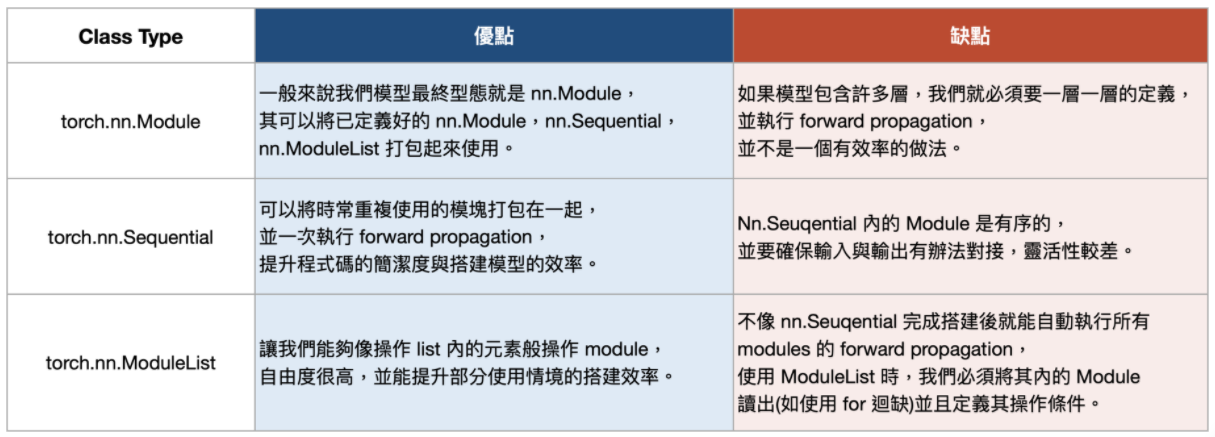